# Baseline xgb

# Table of contents

[Data Loading](#data_loading)

[JSON Parsing](#json_parsing)

[Data Aggregation](#data_aggregation)

[Feature Engineering](#fe)

[NLP](#nlp)

[Image Metadata Extraction](#image_metadata)

[Image Processing](#cv)

[Training](#training)

In [1]:
import gc
import glob
import os
from os import path
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook
import cv2
from PIL import Image
from collections import Counter
from functools import partial
from math import sqrt
import time
from functools import reduce
from numba import cuda
import math

import numpy as np
import pandas as pd
import scipy as sp
import xgboost as xgb
import lightgbm as lgb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.model_selection import StratifiedKFold, GroupKFold

from keras.applications.densenet import preprocess_input, DenseNet121
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K

%matplotlib inline

np.random.seed(seed=1)
warnings.filterwarnings('ignore')

split_char = '/'

img_size = 256
batch_size = 256

Using TensorFlow backend.


<a id='data_loading'></a>
## Data loading

In [2]:
data_path = '../input/petfinder-adoption-prediction/'
train = pd.read_csv(path.join(data_path, 'train/train.csv'))
test = pd.read_csv(path.join(data_path, 'test/test.csv'))
y_trn = train['AdoptionSpeed']
sample_submission = pd.read_csv(path.join(data_path, 'test/sample_submission.csv'))

labels_breed = pd.read_csv(path.join(data_path, 'breed_labels.csv'))
labels_state = pd.read_csv(path.join(data_path, 'color_labels.csv'))
labels_color = pd.read_csv(path.join(data_path, 'state_labels.csv'))

In [3]:
def get_filenames(mode='train'):
    
    image_files = sorted(glob.glob(path.join(data_path, '{}_images/*.jpg'.format(mode))))
    metadata_files = sorted(glob.glob(path.join(data_path, '{}_metadata/*.json'.format(mode))))
    sentiment_files = sorted(glob.glob(path.join(data_path, '{}_sentiment/*.json'.format(mode))))
    
    return image_files, metadata_files, sentiment_files

def create_fnames_df(metadata_fnames_list, sentiment_fnames_list):

    # Metadata:
    metadata_fnames = pd.DataFrame(metadata_fnames_list, columns = ['metadata_filename'])
    metadata_fnames['PetID'] = metadata_fnames['metadata_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

    # Sentiment:
    sentiment_fnames = pd.DataFrame(sentiment_fnames_list, columns = ['sentiment_filename'])
    sentiment_fnames['PetID'] = sentiment_fnames['sentiment_filename'].apply(lambda x: x.split(split_char)[-1].split('.')[0])

    return metadata_fnames, sentiment_fnames

In [4]:
train_image_files, train_metadata_files, train_sentiment_files = get_filenames('train')
print('num of train images files: {}'.format(len(train_image_files)))
print('num of train metadata files: {}'.format(len(train_metadata_files)))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))

test_image_files, test_metadata_files, test_sentiment_files = get_filenames('test')
print('num of test images files: {}'.format(len(test_image_files)))
print('num of test metadata files: {}'.format(len(test_metadata_files)))
print('num of test sentiment files: {}'.format(len(test_sentiment_files)))

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442
num of test images files: 15040
num of test metadata files: 15040
num of test sentiment files: 3815


In [5]:
metadata_fnames_trn, sentiment_fnames_trn = create_fnames_df(train_metadata_files, train_sentiment_files)
metadata_fnames_test, sentiment_fnames_test = create_fnames_df(test_metadata_files, test_sentiment_files)

<a id="json_parsing"></a>
## JSON parsing

In [7]:
def open_json_file(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        json_file = json.load(f)
    return json_file

def parse_sentiment_file(file):
    """
    Parse sentiment file. Output DF with sentiment features.
    """

    file_sentiment = file['documentSentiment']
    file_entities = [x['name'] for x in file['entities']]
    file_entities = ' '.join(file_entities)

    file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]

    file_sentences_sentiment = pd.DataFrame.from_dict(
        file_sentences_sentiment, orient='columns')
    file_sentences_sentiment_df = pd.DataFrame(
        {
            'magnitude_sum': file_sentences_sentiment['magnitude'].sum(axis=0),
            'score_sum': file_sentences_sentiment['score'].sum(axis=0),
            'magnitude_mean': file_sentences_sentiment['magnitude'].mean(axis=0),
            'score_mean': file_sentences_sentiment['score'].mean(axis=0),
            'magnitude_var': file_sentences_sentiment['magnitude'].var(axis=0),
            'score_var': file_sentences_sentiment['score'].var(axis=0),
        }, index=[0]
    )

    df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
    df_sentiment = pd.concat([df_sentiment, file_sentences_sentiment_df], axis=1)

    df_sentiment['entities'] = file_entities
    df_sentiment = df_sentiment.add_prefix('sentiment_')

    return df_sentiment
    
def parse_metadata_file(file, is_first_img):
    """
    Parse metadata file. Output DF with metadata features.
    """

    file_keys = list(file.keys())
    
    
    # label annotations
    
    if 'labelAnnotations' in file_keys:
        file_annots = file['labelAnnotations']
        scores = np.asarray([x['score'] for x in file_annots])
        scores_max_idx = scores.argmax()
        file_top_score = scores[scores_max_idx]
        file_mean_score = scores.mean()
        file_top_desc = [x['description'] for x in file_annots]
#         file_top_desc = file_annots[scores_max_idx]['description']
        file_num_annots = len(file_annots)
    else:
        file_top_score = np.nan
        file_top_desc = ['']
        file_mean_score = np.nan
        file_num_annots = 0


    # image properties annotation
    
    # colors    
    file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
    color_max_idx = np.asarray([x['score'] for x in file_colors]).argmax()
    color_max_score = file_colors[color_max_idx]['color']
    if 'red' in color_max_score and 'green' in color_max_score and 'blue' in color_max_score:
        color_max_red = color_max_score['red']
        color_max_green = color_max_score['green']
        color_max_blue = color_max_score['blue']
    else:
        color_max_red = 0
        color_max_green = 0
        color_max_blue = 0
    file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
    file_color_score_max = file_colors[color_max_idx]['score']
    
    file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).sum()
    file_color_pixelfrac_mean = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

    df_metadata = {
        'annots_score': file_top_score,
        'annots_mean_score': file_mean_score,
        'color_score': file_color_score,
        'max_color_score': file_color_score_max,
        'max_red': color_max_red,
        'max_green': color_max_green,
        'max_blue': color_max_blue,
        'color_pixelfrac': file_color_pixelfrac,
        'color_pixelfrac_mean': file_color_pixelfrac_mean,
        'annots_top_desc': ' '.join(file_top_desc),
        'num_annots': file_num_annots,
        'is_first_img': is_first_img,
    }

    df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
    df_metadata = df_metadata.add_prefix('metadata_')

    return df_metadata
    

def extract_features_for_id(pet_id, mode='train'):
    if len(pet_id) > 20:
        print(pet_id)
    sentiment_filename = path.join(data_path, '{}_sentiment/{}.json'.format(mode, pet_id))
    try:
        sentiment_file = open_json_file(sentiment_filename)
        df_sentiment = parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob('../input/petfinder-adoption-prediction/{}_metadata/{}*.json'.format(mode, pet_id)))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = open_json_file(f)
            is_first_img = '-1' == f[f.index('.json')-2:f.index('.json')]
            df_metadata = parse_metadata_file(metadata_file, is_first_img)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True)
    dfs = [df_sentiment, dfs_metadata]
    
    return dfs

def extract_features_for_ids(pet_ids, mode='train'):
    dfs = Parallel(n_jobs=-1, verbose=1)(
            delayed(extract_features_for_id)(i, mode=mode) for i in pet_ids)
    sentiment_dfs = [x[0] for x in dfs if isinstance(x[0], pd.DataFrame)]
    metadata_dfs = [x[1] for x in dfs if isinstance(x[1], pd.DataFrame)]
    sentiment_dfs = pd.concat(sentiment_dfs, ignore_index=True)
    metadata_dfs = pd.concat(metadata_dfs, ignore_index=True)
    
    return sentiment_dfs, metadata_dfs

In [8]:
sentiment_trn, metadata_trn = extract_features_for_ids(train.PetID, mode='train')
sentiment_test, metadata_test = extract_features_for_ids(test.PetID, mode='test')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 4793 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6693 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 8793 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 11093 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 13593 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 14993 out of 14993 | elapsed:  4.5min finished
[Parallel(n_jobs=-1)]: Using bac

<a id='image_metadata'></a>
## Image Metadata Extraction

In [9]:
def getSize(filename):
    st = os.stat(filename)
    return st.st_size

def getDimensions(filename):
    img_size = Image.open(filename).size
    return img_size 

def extract_image_metadata(image_files):
    
    images_df = pd.DataFrame(image_files)
    images_df.columns = ['image_filename']
    images_ids = images_df['image_filename'].apply(lambda x: x.split(split_char)[-1].split('-')[0])

    images_df = images_df.assign(PetID=images_ids)
    
    images_df['image_size'] = images_df['image_filename'].apply(getSize)
    images_df['temp_size'] = images_df['image_filename'].apply(getDimensions)
    images_df['width'] = images_df['temp_size'].apply(lambda x : x[0])
    images_df['height'] = images_df['temp_size'].apply(lambda x : x[1])
    images_df = images_df.drop(['temp_size'], axis=1)
    
    aggs = {
        'image_size': ['sum', 'mean'],
        'width': ['sum', 'mean'],
        'height': ['sum', 'mean'],
    }

    agg_imgs = images_df.groupby('PetID').agg(aggs)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    agg_imgs.columns = new_columns
    agg_imgs = agg_imgs.reset_index()
    
    first_img_df = image_files
    
    

    return agg_imgs

In [10]:
image_metadata_trn = extract_image_metadata(train_image_files)
image_metadata_test = extract_image_metadata(test_image_files)

<a id="data_aggregation"></a>
## Data Aggregation and Preprocessing

In [312]:
nn_trn = pd.read_csv('nn_train.csv')
nn_test = pd.read_csv('nn_test.csv')

In [12]:
aggregates = ['sum', 'mean', 'max']
sent_agg = ['sum']

def aggregate_df(ids, metadata_df, sentiment_df):
    
    # Train

    # metadata

    # join all the annotations top desc
    metadata_desc = metadata_df.groupby(['PetID'])['metadata_annots_top_desc'].unique()
    metadata_desc = metadata_desc.reset_index()
    metadata_desc['metadata_annots_top_desc'] = metadata_desc['metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

#     metadata_face_annot = metadata_df.groupby('PetID')['metadata_has_face_annot'].any().to_frame().reset_index()
#     metadata_text_annot = metadata_df.groupby('PetID')['metadata_has_text_annot'].any().to_frame().reset_index()
                                    
    # conver to float
    metadata_gr = metadata_df.drop(['metadata_annots_top_desc', 'metadata_is_first_img'], axis=1)
    
    
    for i in metadata_gr.columns:
        if 'PetID' not in i:
            metadata_gr[i] = metadata_gr[i].astype(np.float32)

    # apply sum, mean, var to all pets with multiple data pts
    metadata_gr = metadata_gr.groupby(['PetID']).agg(aggregates)
    metadata_gr.columns = pd.Index(['{}_{}'.format(c[0], c[1].upper()) for c in metadata_gr.columns.tolist()])
    metadata_gr = metadata_gr.reset_index()

    first_img_df = metadata_df[metadata_df['metadata_is_first_img'] == True].add_suffix('_FIRST')
    
    first_img_df = first_img_df.rename({'PetID_FIRST': 'PetID'}, axis='columns')
    
    metadata_gr = metadata_gr.merge(first_img_df, on='PetID', how='left')
    
    
    # sentiment

    # join unique sentiment entities
    sentiment_desc = sentiment_df.groupby(['PetID'])['sentiment_entities'].unique()
    sentiment_desc = sentiment_desc.reset_index()
    sentiment_desc[
        'sentiment_entities'] = sentiment_desc[
        'sentiment_entities'].apply(lambda x: ' '.join(x))

    # apply sum to all pets with multiple data pts
    sentiment_gr = sentiment_df.drop(['sentiment_entities'], axis=1)
    for i in sentiment_gr.columns:
        if 'PetID' not in i:
            sentiment_gr[i] = sentiment_gr[i].astype(float)
    sentiment_gr = sentiment_gr.groupby(['PetID']).agg(sent_agg)
    sentiment_gr.columns = pd.Index(['{}'.format(c[0]) for c in sentiment_gr.columns.tolist()])
    sentiment_gr = sentiment_gr.reset_index()
    
    merged_df = pd.DataFrame(ids, columns = ['PetID'])
    merged_df = merged_df.merge(sentiment_gr, how='left', on='PetID')
    merged_df = merged_df.merge(sentiment_desc, how='left', on='PetID')
    merged_df = merged_df.merge(metadata_gr, how='left', on='PetID')
    merged_df = merged_df.merge(metadata_desc, how='left', on='PetID')
    
#     merged_df = merged_df.merge(metadata_face_annot, how='left', on='PetID')
#     merged_df = merged_df.merge(metadata_text_annot, how='left', on='PetID')
    
    
    return merged_df

In [336]:
meta_senti_trn = aggregate_df(train.PetID, metadata_trn, sentiment_trn)
meta_senti_test = aggregate_df(test.PetID, metadata_test, sentiment_test)

In [337]:
nn_trn_agg = nn_trn.groupby('PetID').agg(['sum', 'mean', 'max']).reset_index()
nn_test_agg = nn_test.groupby('PetID').agg(['sum', 'mean', 'max']).reset_index()

nn_trn_agg.columns = ['PetID', 'nn_sum', 'nn_mean', 'nn_max']
nn_test_agg.columns = ['PetID', 'nn_sum', 'nn_mean', 'nn_max']

In [338]:
meta_senti_trn = meta_senti_trn.merge(nn_trn_agg, on='PetID', how='left')
meta_senti_test = meta_senti_test.merge(nn_test_agg, on='PetID', how='left')

In [339]:
meta_dfs_trn = [train, meta_senti_trn, image_metadata_trn]
meta_dfs_test = [test, meta_senti_test, image_metadata_test]

stage1_trn = reduce(lambda left,right: pd.merge(left, right, on=['PetID'], how='left'), meta_dfs_trn)
stage1_test = reduce(lambda left,right: pd.merge(left, right, on=['PetID'], how='left'), meta_dfs_test)

<a id="fe"></a>
## Feature Engineering

In [ ]:
def get_breed_df(df): 
    breed_primary = df[['Breed1']].merge(labels_breed, how='left', left_on='Breed1', right_on='BreedID', 
                                               suffixes=('', '_primary_breed'))[['BreedName', 'Type']]
    breed_primary = breed_primary.add_prefix('primary_')

    breed_secondary = df[['Breed2']].merge(labels_breed, how='left', left_on='Breed2', right_on='BreedID', 
                                               suffixes=('', '_secondary_breed'))[['BreedName', 'Type']]
    breed_secondary = breed_secondary.add_prefix('secondary_')
    
    combined_breed = pd.concat([breed_primary, breed_secondary], axis=1)
    
    mask1 = combined_breed['primary_BreedName']=='Mixed Breed'
    mask2 = combined_breed['secondary_BreedName'].isnull()
    combined_breed.loc[mask1 & mask2, 'secondary_BreedName'] = 'Mixed Breed'
    
    combined_breed['primary_BreedName'].fillna(combined_breed['secondary_BreedName'], inplace=True)
    combined_breed['primary_Type'].fillna(combined_breed['secondary_Type'], inplace=True)
    combined_breed['secondary_BreedName'].fillna('Pure Breed', inplace=True)
    combined_breed = combined_breed.drop(['primary_Type','secondary_Type'], axis=1)
    combined_breed['PetID'] = df['PetID']
    
    return combined_breed

In [ ]:
breed_trn = get_breed_df(train)
breed_test = get_breed_df(test)

In [340]:
stage2_trn = stage1_trn.merge(breed_trn, on=['PetID'], how='left')
stage2_test = stage1_test.merge(breed_test, on=['PetID'], how='left')

In [21]:
def generate_count_feature(df, col, counts=None):
    if counts is None:
        feature = df[col]
        groups = df.groupby(col)
        counts = groups.size()
        
    count_feature = df[col].map(counts)
    
    return count_feature, counts

def encode_FE(df,col,verbose=0):
    ln = 1/df[col].nunique()
    vc = (df[col].value_counts(dropna=False, normalize=True)+ln).map(math.log).to_dict()
    nm = col+'_counts'
    df[nm] = df[col].map(vc)
    df[nm] -= df[nm].min()
    df[nm] = df[nm]/df[nm].max()
    df[nm] = df[nm].astype('float32')
    if verbose==1:
        print('count encoded',col)
        

# def generate_count_df(df, cols, counts_map={}):
#     for col in cols:
#         if col in counts_map:
#             count_df[col + '_counts'], _ = generate_count_feature(df, col, counts=counts_map[col])
#         else:
#             count_df[col + '_counts'], counts_map[col] = generate_count_feature(df, col)
        
#     return count_df, counts_map



# def generate_freq_feature(df, col, on='AdoptionSpeed', frequencies=None):

#     if frequencies is None:
#         groups = df.groupby(col)
#         sizes = groups.size()
#         sums = groups.sum()[on]
#         frequencies = sums/sizes
#     freq_feature = df[col].map(frequencies)
    
#     return freq_feature, frequencies

# def generate_freq_df(df, cols, freqs_map={}):
#     freq_df = pd.DataFrame()
#     for col in cols:
#         if col in freqs_map:
#             freq_df[col + '_freqs'], _ = generate_freq_feature(df, col, frequencies=freqs_map[col])
#         else:
#             freq_df[col + '_freqs'],  freqs_map[col] =  generate_freq_feature(df, col)
            
#     return freq_df, freqs_map

def generate_smoothed_count_feature(df, col, counts=None):
    if counts is None:
        _, counts = generate_count_feature(df, col)

    sorted_keys = sorted(df[col].unique())
    sorted_vals = np.pad([counts[x] for x in sorted_keys], 2, 'edge')
    new_vals = []
        
    for i in range(len(sorted_keys)):
        new_vals.append(0.1*sorted_vals[i] + 0.2*sorted_vals[i+1] + 0.4*sorted_vals[i+2] + 0.2*sorted_vals[i+3] + 0.1*sorted_vals[i+4])
    
    smoothed = df[col].map(dict(zip(sorted_keys, new_vals)))
    return smoothed

In [23]:
def splitnonalpha(s):
    idx = 1
    while idx < len(s) and s[idx].isalpha():
        idx+=1
    return s[:idx]

def feature_engineer_1(df):

    fe = pd.DataFrame()
    fe['Length_Description'] = df['Description'].astype(str).map(len)
    fe['Length_metadata_annots_top_desc'] = df['metadata_annots_top_desc'].astype(str).map(len)
    fe['Lengths_sentiment_entities'] = df['sentiment_entities'].astype(str).map(len)
    
    df['Name'] = df['Name']
    df['Name'] = df['Name'].str.lower().replace(['no name', 'noname', np.nan], '')
    df['Name'] = df['Name'].map(splitnonalpha)
    fe['NameLength'] = df['Name'].map(len)
    
    fe['FeeOrNot'] = df['Fee'] > 0
    
    fe['Purebred'] = df['secondary_BreedName'] == 'Pure Breed'
    
    fe['Status'] = (df['Vaccinated'] == 1).astype(int) + (df['Dewormed'] == 1).astype(int) + (df['Sterilized'] == 1).astype(int) + (df['Health'] == 1).astype(int) 
    
    rescuers_gb = df.groupby(['RescuerID']).agg({'Age': 'median'}).reset_index()
    with_avg_age = df.merge(rescuers_gb, on='RescuerID', how='left', suffixes=('', '_rescuer_mean'))
    fe['RescuerID_relative_age'] = with_avg_age['Age']-with_avg_age['Age_rescuer_mean']
    fe['Age_rescuer_mean'] = with_avg_age['Age_rescuer_mean']
    
    rescuers_gb = df.groupby(['RescuerID', 'Type']).agg('count').reset_index()[['RescuerID', 'Type', 'Name']]
    num_types = df.merge(rescuers_gb, on=['RescuerID', 'Type'], how='left', suffixes=('', '_rescuer_num'))
    fe['Type_rescuer_sum'] = num_types['Name_rescuer_num']
    
    rescuers_gb = df.groupby(['RescuerID']).agg({'Type': 'mean'}).reset_index()
    avg_type = df.merge(rescuers_gb, on='RescuerID', how='left', suffixes=('', '_rescuer_avg'))
    fe['Type_rescuer_avg'] = avg_type['Type_rescuer_avg']
    
    rescuers_gb = df.groupby(['RescuerID']).agg({'Quantity': 'sum'}).reset_index()
    sum_quantity = df.merge(rescuers_gb, on='RescuerID', how='left', suffixes=('', '_rescuer_sum'))
    fe['Quantity_rescuer_sum'] = sum_quantity['Quantity_rescuer_sum']
    
    return fe

In [341]:
fe1_trn = feature_engineer_1(stage2_trn)
fe1_test = feature_engineer_1(stage2_test)

stage3_trn = stage2_trn.join(fe1_trn)
stage3_test = stage2_test.join(fe1_test)

In [237]:
def encode_CE(df, col, filt, zscore, label='AdoptionSpeed', m=0.5, verbose=1): 
    
    # get counts
    df_counts = pd.DataFrame(df[col].value_counts(dropna=False)).reset_index()
    
    # get mean of label per category
    df_mean = df.groupby(col)[label].mean().reset_index().rename({label:'rate',col:'index'},axis=1)
    
    # combine
    df_ce = pd.merge(df_counts, df_mean, on='index', how='left')
    
    
    # if the value is null to begin with, then set the CE value to the mean of null values
    if (len(df_ce[df_ce['index'].isna()])!=0 ):
        df_ce.loc[df_ce['index'].isna(), 'rate'] = df.loc[df[col].isna(), label].mean()
    
    d1 = set(df_ce['index'].unique())
    # delete categories with less than 0.1% occurance rate
    df_ce = df_ce[df_ce[col] > (filt * len(df))]

    # sum of labels minus sum of categories' labels divided by number of other categories?
    df_ce['ratec'] = (df[label].sum() - df_ce['rate']*df_ce[col])/(len(df)-df_ce[col])

    df_ce['sd'] = zscore * 0.5 / df_ce[col].map(lambda x: math.sqrt(x))
    
    df_ce = df_ce[ (abs(df_ce['rate']-m)>=df_ce['sd']) | (abs(df_ce['ratec']-1+m)>=df_ce['sd']) ]

    d2 = set(df_ce['index'].unique())
    
    d = list(d1 - d2)
    if (df[col].dtype.name=='category'):
        if (not 0 in df[col].cat.categories):
            df[col].cat.add_categories(0,inplace=True)
        else:
            print('###WARNING CAT 0 ALREADY EXISTS IN',col)

    df.loc[ df[col].isin(d),col ] = 0
    if verbose==1:
        print('CE encoded',col,'-',len(d2),'values. Removed',len(d),'values')
    mx = df[col].nunique()
    
    df[col+'_CE'] = df[col].map(dict(zip(df_ce['index'], df_ce['rate'])))
    df[col+'_CE'] = df[col+'_CE'].fillna(df_ce['rate'].mean())
    
    return [df_ce,d2]

def encode_CE_test(df,col,d,df_ce):
    if (df[col].dtype.name=='category'):
        if (not 0 in df[col].cat.categories):
            df[col].cat.add_categories(0,inplace=True)
        else:
            print('###WARNING CAT 0 ALREADY EXISTS IN',col)
    df.loc[ ~df[col].isin(d),col ] = 0
    mx = df[col].nunique()
    
    df[col+'_CE'] = df[col].map(dict(zip(df_ce['index'], df_ce['rate'])))
    df[col+'_CE'] = df[col+'_CE'].fillna(df_ce['rate'].mean())
    
    return [mx,d]

In [342]:
freq_cols = ['Breed1', 'Color1', 'Breed2', 'Sterilized', 'PhotoAmt', 'State', 'Vaccinated', 'Dewormed',
                 'primary_BreedName', 'secondary_BreedName']
    
for freq_col in freq_cols:
    ce_dat = encode_CE(stage3_trn, freq_col, 0.001, 1)
    encode_CE_test(stage3_test, freq_col, ce_dat[1], ce_dat[0])
    
y = stage3_trn['AdoptionSpeed']
stage3_trn = stage3_trn.drop('AdoptionSpeed', axis=1)

CE encoded Breed1 - 53 values. Removed 123 values
CE encoded Color1 - 7 values. Removed 0 values
CE encoded Breed2 - 33 values. Removed 102 values
CE encoded Sterilized - 3 values. Removed 0 values
CE encoded PhotoAmt - 24 values. Removed 7 values
CE encoded State - 12 values. Removed 2 values
CE encoded Vaccinated - 3 values. Removed 0 values
CE encoded Dewormed - 3 values. Removed 0 values
CE encoded primary_BreedName - 53 values. Removed 122 values
CE encoded secondary_BreedName - 33 values. Removed 102 values


In [343]:
categorical_columns = ['primary_BreedName', 'secondary_BreedName']

X = pd.concat([stage3_trn, stage3_test])

for i in categorical_columns:
    X.loc[:, i] = pd.factorize(X.loc[:, i])[0]
X = X.reset_index(drop=True)

global_counts_cols = ['RescuerID', 'State', 'Breed1', 'Color1', 'Breed2', 'primary_BreedName', 'secondary_BreedName']
for freq_col in global_counts_cols:
    encode_FE(X, freq_col)

X['Age_counts'] = generate_smoothed_count_feature(X, 'Age')

<a id='nlp'></a>
## NLP

In [29]:
text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']
#

X_text = X[text_columns]

n_components = 32
text_features = []

# Generate text features:
for col in X_text.columns:
    
    X_text[col] = X_text[col].fillna('none')
    
    # Initialize decomposition methods:
    print('generating features from: {}'.format(col))
    tfv = TfidfVectorizer(min_df=2,  max_features=10000,
                          strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
                          ngram_range=(1, 3), use_idf=1, smooth_idf=1, sublinear_tf=1)
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1)
    
    tfidf_col = tfv.fit_transform(X_text.loc[:, col].values)
    
    svd_col = svd_.fit_transform(tfidf_col)
    
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('TFIDF_{}_'.format(col))
    
    text_features.append(svd_col)
    
text_features = pd.concat(text_features, axis=1)

generating features from: Description
generating features from: metadata_annots_top_desc
generating features from: sentiment_entities


In [344]:
X = pd.concat([X, text_features], axis=1)
X = X.drop(X_text.columns, axis=1)

<a id='cv'></a>
## Image processing and densenet

In [22]:
def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread('{}{}-1.jpg'.format(path, pet_id))
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

In [20]:
inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, 
                       weights="../input/densenet/DenseNet-BC-121-32-no-top.h5",
                       include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

In [24]:
pet_ids = train['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image("../input/petfinder-adoption-prediction/train_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]

100%|██████████| 59/59 [01:35<00:00,  1.62s/it]


In [25]:
train_feats = pd.DataFrame.from_dict(features, orient='index')
train_feats.columns = ['pic_{}'.format(str(i)) for i in range(train_feats.shape[1])]

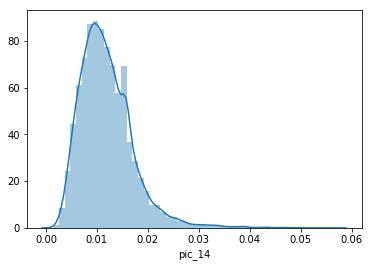

In [42]:
sns.distplot(train_feats['pic_14'])

In [ ]:
sns.distplot(train_feats['pic_1'])

In [43]:
pet_ids = test['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image("../input/petfinder-adoption-prediction/test_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]

100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


In [36]:
del m
gc.collect()

cuda.select_device(0)
cuda.close()

In [44]:
test_feats = pd.DataFrame.from_dict(features, orient='index')
test_feats.columns = ['pic_{}'.format(i) for i in range(test_feats.shape[1])]

In [45]:
train_feats = train_feats.reset_index()
train_feats.rename({'index': 'PetID'}, axis='columns', inplace=True)

test_feats = test_feats.reset_index()
test_feats.rename({'index': 'PetID'}, axis='columns', inplace=True)

In [46]:
all_ids = pd.concat([train, test], axis=0, ignore_index=True)[['PetID']]
all_ids.shape

(18941, 1)

In [47]:
n_components = 32
svd_ = TruncatedSVD(n_components=n_components, random_state=1337)

features_df = pd.concat([train_feats, test_feats], axis=0)
features = features_df[['pic_{}'.format(i) for i in range(256)]].values

svd_col = svd_.fit_transform(features)
svd_col = pd.DataFrame(svd_col)
svd_col = svd_col.add_prefix('IMG_SVD_')

img_features = pd.concat([all_ids, svd_col], axis=1)

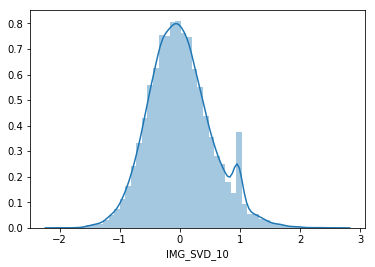

In [59]:
sns.distplot(img_features['IMG_SVD_10'])

In [345]:
X = X.merge(img_features, on='PetID', how='left')

<a id="data_cleaning"></a>
## Data Cleaning

In [346]:
to_drop_columns = ['Name', 'RescuerID', 'Breed1', 'Breed2', 'metadata_annots_top_desc_FIRST', 'metadata_is_first_img_FIRST']
X = X.drop(to_drop_columns, axis=1)

for c in X.columns:
    if X[c].isnull().sum() > 1000:
        X = X.drop(c, axis=1)
        print('Dropped {}'.format(c))
        
for col in X.columns:
    X[col] = X[col].fillna(0)

In [347]:
# X.to_csv('processed_data.csv')

In [348]:
to_drop_columns = ['PetID']
X = X.drop(to_drop_columns, axis=1)

cat_cols = ['Type', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
            'Sterilized', 'Health', 'State', #'primary_BreedName', 'secondary_BreedName',
            'Color1', 'Color2', 'Color3']

for c in cat_cols:
    X = X.join(pd.get_dummies(X[c], prefix=c))
X = X.drop(cat_cols, axis=1)
X_trn = X[:len(train)]
X_test = X[len(train):]

## Aversarial validation

In [349]:
av_trn = X_trn.copy()
av_test = X_test.copy()
av_trn['lab'] = 1
av_test['lab'] = 0

av_comb = pd.concat([av_trn, av_test])
av_lab = av_comb['lab'].values
av_comb = av_comb.drop('lab', axis=1)
av_dat = lgb.Dataset(av_comb, label=av_lab)

av_mod = lgb.train(lgb_params, av_dat)
av_df = pd.DataFrame({'feature': av_comb.columns, 'importance': av_mod.feature_importance()})

In [350]:
av_df.sort_values(by='importance', ascending=False)

,feature,importance
53,nn_sum,570
54,nn_mean,563
55,nn_max,335
73,Type_rescuer_sum,248
86,RescuerID_counts,193
75,Quantity_rescuer_sum,182
4,PhotoAmt,137
72,Age_rescuer_mean,102
56,height_sum,83
40,metadata_num_annots_SUM,78


<a id='training'></a>
## Training

In [351]:
# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [352]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return -cohen_kappa_score(y, preds, weights='quadratic')
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
    
    def predict(self, X, coef):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [353]:
def train_and_test_model(X, y, X_test, params, num_folds=5, plot_feature_importance=True, use_group_kfold=False,
                         model_type='lgb'):
    result_dict = {}
    feature_importance = pd.DataFrame()
    fold_predictions = []
    val_preds = np.zeros((X.shape[0]))
    if use_group_kfold:
        folds = GroupKFold(n_splits=num_folds)
        fold_split = folds.split(X, y, train['RescuerID'])
    else:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
        fold_split = folds.split(X, y)
    
    if X_test is not None:
        result_dict['averaged_prediction'] =  np.zeros(len(X_test))
    else:
        result_dict['averaged_prediction'] =  np.zeros(1)
    counter = 0
    result_dict['feature_importance'] = []
    result_dict['predictions'] = []
    
    for fold_n, (idx_trn, idx_val) in enumerate(fold_split):

        print('Fold {}\n'.
              format(counter + 1))
         
        X_trn = X.iloc[idx_trn]
        X_val = X.iloc[idx_val]

        
#         X_trn, X_val = csr_matrix(X_trn, dtype='float32'), csr_matrix(X_val, dtype='float32')
        y_trn, y_val = y[idx_trn], y[idx_val]

    
        if model_type == 'lgb':
            dat_trn = lgb.Dataset(X_trn, label=y_trn)
            dat_val = lgb.Dataset(X_val, label=y_val)

            print('Beginning training...')
            start_time = time.time()
            model = lgb.train(params, dat_trn, valid_sets = [dat_trn, dat_val], verbose_eval=100, num_boost_round=1200, early_stopping_rounds=100)
            print('Training took {0:.2f} minutes.'.format((time.time()-start_time)/60))

            y_val_hat = model.predict(X_val, num_iteration=model.best_iteration)
            val_preds[idx_val] = y_val_hat
            
            if X_test is not None:
                start_time = time.time()
                y_hat = model.predict(X_test, num_iteration=model.best_iteration)
                result_dict['predictions'].append(y_hat)
                result_dict['averaged_prediction'] += y_hat
                print('Prediction took {0:.2f} minutes.'.format((time.time()-start_time)/60))
                
            feature_df = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importance()})
            result_dict['feature_importance'].append(feature_df)
            sorted_feat = feature_df.sort_values(by='importance', ascending=False)
            plt.figure(figsize=(10, 10))
            sns.barplot(x='importance', y='feature', data=sorted_feat[:50])
#             print('Most useless features: ')
#             print(sorted_feat[-20:])
            plt.title('LGB Features for fold')
            plt.show()
            
            gc.collect()
            
        elif model_type == 'xgb':
            dat_trn = xgb.DMatrix(data=X_trn, label=y_trn, feature_names=X_trn.columns)
            dat_val = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)

            watchlist = [(dat_trn, 'train'), (dat_val, 'valid')]
            model = xgb.train(dtrain=dat_trn, num_boost_round=2000, evals=watchlist,
                             early_stopping_rounds=100, verbose_eval=100, params=params)

            y_hat_val = model.predict(xgb.DMatrix(X_val, feature_names=X_val.columns), ntree_limit=model.best_ntree_limit)
            val_preds[idx_val] = y_hat_val
            
            y_hat = model.predict(xgb.DMatrix(X_test, feature_names=X_test.columns), ntree_limit=model.best_ntree_limit)
            result_dict['predictions'].append(y_hat)
            result_dict['averaged_prediction'] += y_hat
#             xgb.plot_importance(model, height=1.0, ax=ax, max_num_features=50)
#             plt.show()
        del dat_trn, dat_val, X_trn, X_val
        counter += 1
            
        
        

    result_dict['val_preds'] = val_preds
    if X_test is not None:
        result_dict['averaged_prediction'] /= counter
        
    return result_dict


In [379]:
lgb_params = {
    'learning_rate': 0.01,
    'max_depth': -1, # smaller max depth for less overfitting
    'num_leaves': 31, # smaller num leaves for less overfitting
    'min_data_in_leaf': 50, # larger min data for less overfitting
    'max_bin': 31, # smaller max bin for less overfitting
    'feature_fraction': 0.7, # smaller for less overfitting
    'bagging_fraction': 0.7, # smaller for less overfitting
    'bagging_freq': 20, # smaller for less overfitting
    'lambda_l1': 1, # larger for less overfitting
    'lambda_l2': 2, # larger for less overfitting
    'objective': 'regression_l2',
}

bin_params = {
    'learning_rate': 0.001,
    'max_depth': -1, # smaller max depth for less overfitting
    'num_leaves': 15, # smaller num leaves for less overfitting
    'min_data_in_leaf': 100, # larger min data for less overfitting
    'max_bin': 15, # smaller max bin for less overfitting
    'feature_fraction': 0.7, # smaller for less overfitting
    'bagging_fraction': 0.5 , # smaller for less overfitting
    'bagging_freq': 10, # smaller for less overfitting
    'lambda_l1': 3, # larger for less overfitting
    'lambda_l2': 3, # larger for less overfitting
    'objective': 'binary'
}

xgb_params = {
    'eval_metric': 'rmse',
    'booster': 'gbtree',
    'seed': 1,
    'max_depth': 5,
    'min_child_weight': 2,
    'eta': 0.02,
    'subsample': 0.8,
    'colsample_bytree': 0.85, 
    'colsample_bylevel': 0.85,
    'max_bin': 31,
    'tree_method': 'auto',
    'silent': 1,
}

In [380]:
gc.collect()

84

Fold 1

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.13324	valid_1's l2: 1.09201
[200]	training's l2: 1.02188	valid_1's l2: 1.04425
[300]	training's l2: 0.947752	valid_1's l2: 1.0268
[400]	training's l2: 0.889983	valid_1's l2: 1.01996
[500]	training's l2: 0.843194	valid_1's l2: 1.01939
Early stopping, best iteration is:
[432]	training's l2: 0.873873	valid_1's l2: 1.01707
Training took 0.03 minutes.
Prediction took 0.00 minutes.


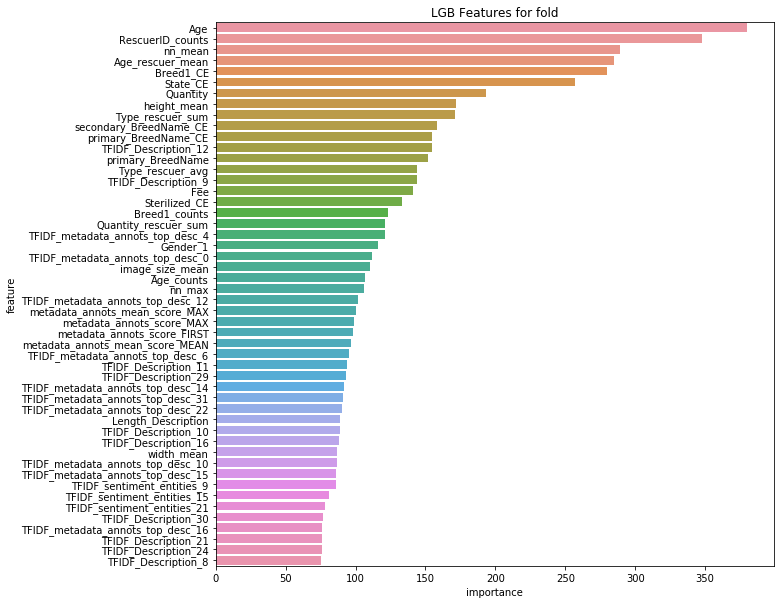

Fold 2

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.12418	valid_1's l2: 1.14
[200]	training's l2: 1.01514	valid_1's l2: 1.08223
[300]	training's l2: 0.943399	valid_1's l2: 1.05708
[400]	training's l2: 0.888633	valid_1's l2: 1.04416
[500]	training's l2: 0.841516	valid_1's l2: 1.03569
[600]	training's l2: 0.801098	valid_1's l2: 1.03302
[700]	training's l2: 0.765019	valid_1's l2: 1.03372
Early stopping, best iteration is:
[671]	training's l2: 0.775259	valid_1's l2: 1.03196
Training took 0.06 minutes.
Prediction took 0.00 minutes.


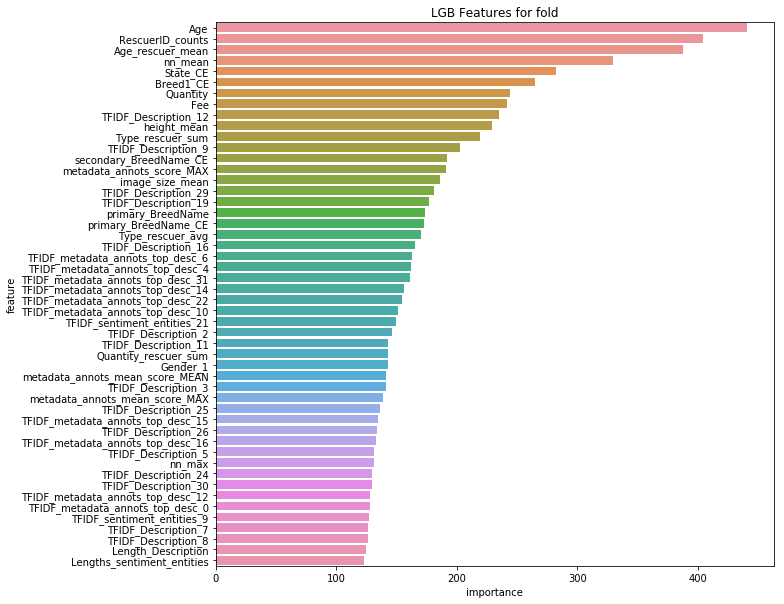

Fold 3

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.12728	valid_1's l2: 1.13106
[200]	training's l2: 1.01443	valid_1's l2: 1.08934
[300]	training's l2: 0.939482	valid_1's l2: 1.07322
[400]	training's l2: 0.883031	valid_1's l2: 1.06613
[500]	training's l2: 0.837293	valid_1's l2: 1.05851
[600]	training's l2: 0.797336	valid_1's l2: 1.05298
Early stopping, best iteration is:
[598]	training's l2: 0.798103	valid_1's l2: 1.05289
Training took 0.05 minutes.
Prediction took 0.00 minutes.


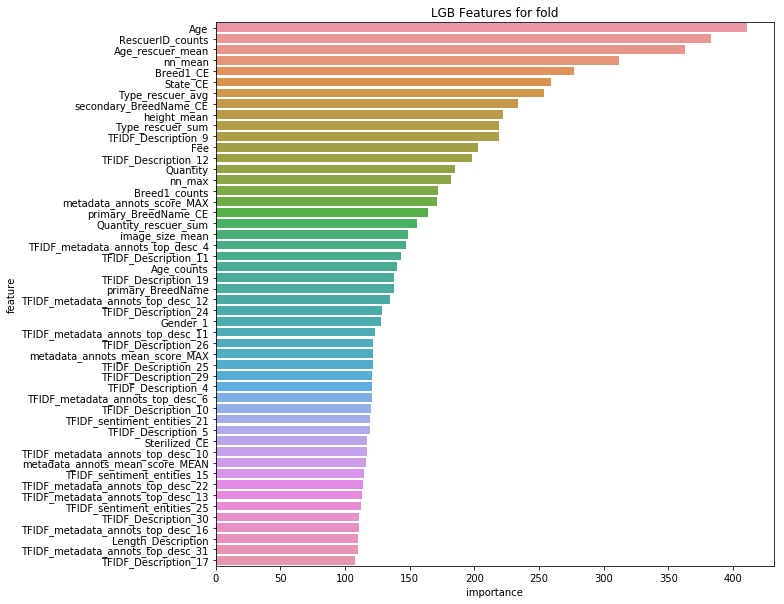

Fold 4

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.12053	valid_1's l2: 1.20147
[200]	training's l2: 1.01114	valid_1's l2: 1.14715
[300]	training's l2: 0.939193	valid_1's l2: 1.11832
[400]	training's l2: 0.882876	valid_1's l2: 1.10666
[500]	training's l2: 0.835589	valid_1's l2: 1.10106
[600]	training's l2: 0.794563	valid_1's l2: 1.10048
Early stopping, best iteration is:
[556]	training's l2: 0.811917	valid_1's l2: 1.09968
Training took 0.04 minutes.
Prediction took 0.00 minutes.


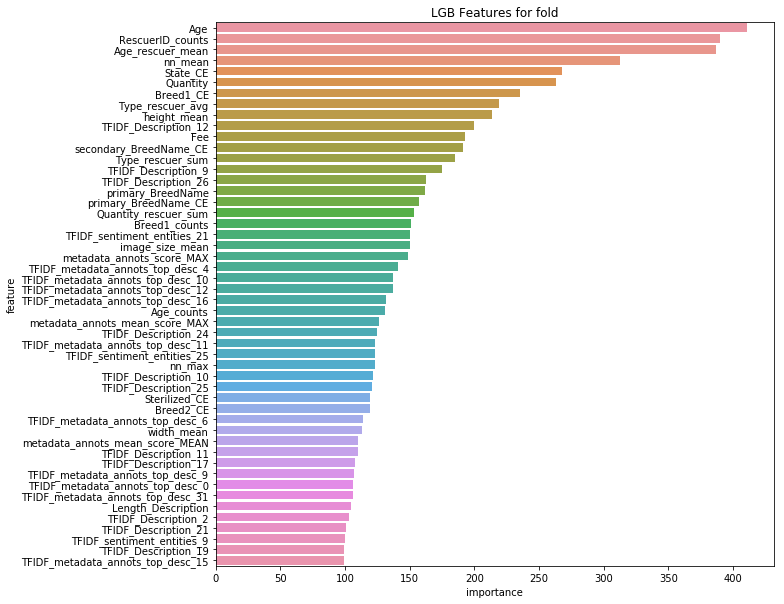

Fold 5

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.12064	valid_1's l2: 1.16212
[200]	training's l2: 1.01286	valid_1's l2: 1.0997
[300]	training's l2: 0.940601	valid_1's l2: 1.07666
[400]	training's l2: 0.885507	valid_1's l2: 1.06599
[500]	training's l2: 0.839379	valid_1's l2: 1.06265
[600]	training's l2: 0.799065	valid_1's l2: 1.06514
Early stopping, best iteration is:
[500]	training's l2: 0.839379	valid_1's l2: 1.06265
Training took 0.04 minutes.
Prediction took 0.00 minutes.


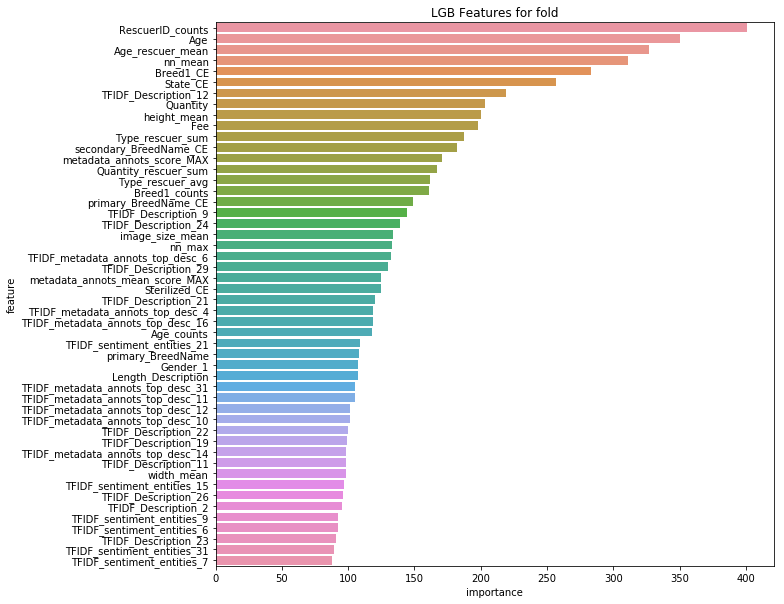

Fold 6

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.11889	valid_1's l2: 1.18301
[200]	training's l2: 1.00644	valid_1's l2: 1.14166
[300]	training's l2: 0.932472	valid_1's l2: 1.1302
[400]	training's l2: 0.877609	valid_1's l2: 1.12445
[500]	training's l2: 0.830687	valid_1's l2: 1.12382
[600]	training's l2: 0.790075	valid_1's l2: 1.1226
[700]	training's l2: 0.753601	valid_1's l2: 1.12557
Early stopping, best iteration is:
[600]	training's l2: 0.790075	valid_1's l2: 1.1226
Training took 0.04 minutes.
Prediction took 0.00 minutes.


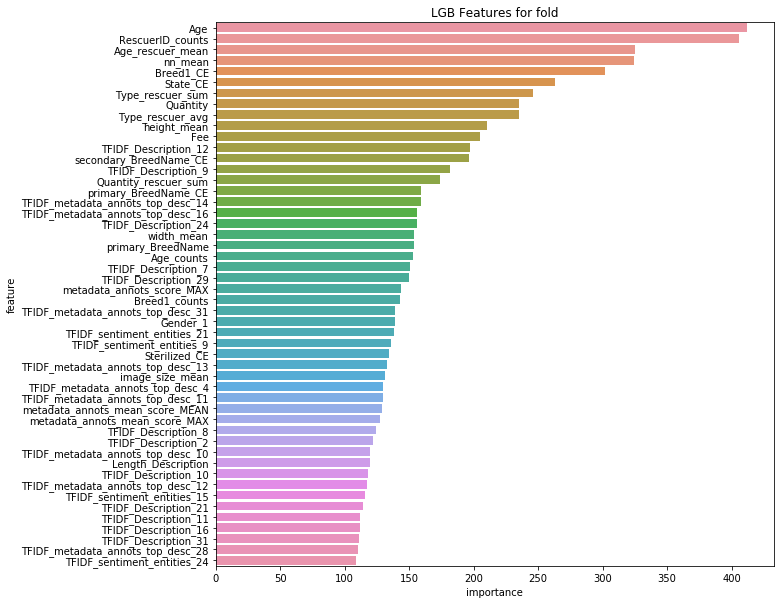

Fold 7

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.11402	valid_1's l2: 1.25431
[200]	training's l2: 1.00733	valid_1's l2: 1.19106
[300]	training's l2: 0.936064	valid_1's l2: 1.16275
[400]	training's l2: 0.879293	valid_1's l2: 1.1508
[500]	training's l2: 0.833012	valid_1's l2: 1.14439
[600]	training's l2: 0.792108	valid_1's l2: 1.13792
[700]	training's l2: 0.755914	valid_1's l2: 1.1341
[800]	training's l2: 0.72224	valid_1's l2: 1.1351
Early stopping, best iteration is:
[746]	training's l2: 0.739845	valid_1's l2: 1.13409
Training took 0.07 minutes.
Prediction took 0.00 minutes.


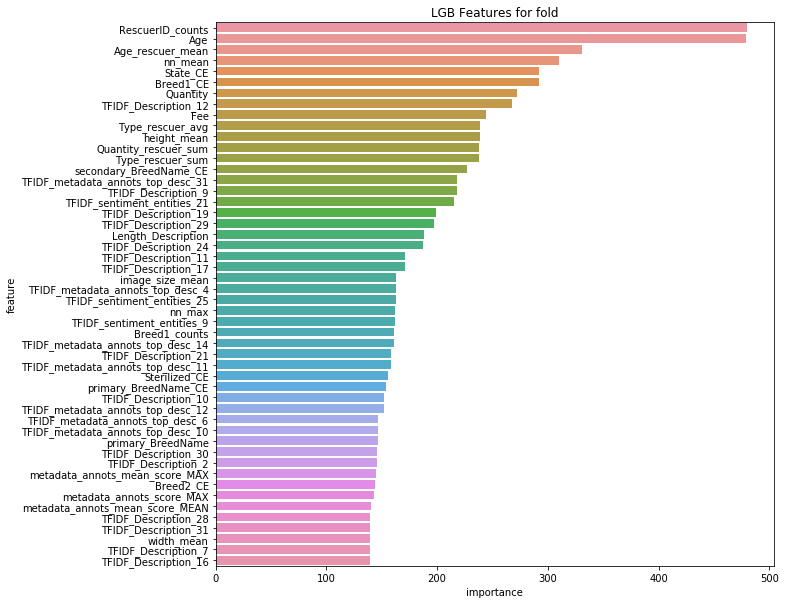

Fold 8

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.1174	valid_1's l2: 1.20663
[200]	training's l2: 1.00806	valid_1's l2: 1.16405
[300]	training's l2: 0.934851	valid_1's l2: 1.14701
[400]	training's l2: 0.878892	valid_1's l2: 1.13606
[500]	training's l2: 0.832858	valid_1's l2: 1.1344
[600]	training's l2: 0.791844	valid_1's l2: 1.13415
Early stopping, best iteration is:
[548]	training's l2: 0.812325	valid_1's l2: 1.13227
Training took 0.04 minutes.
Prediction took 0.00 minutes.


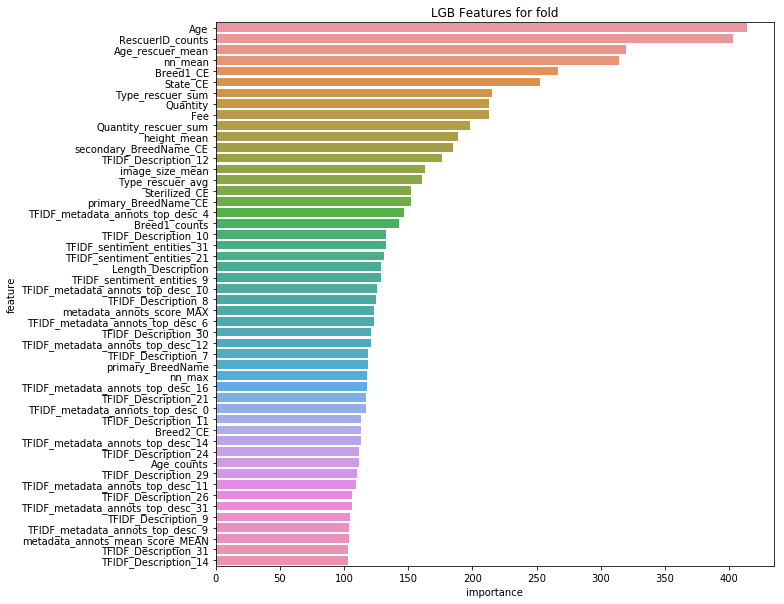

Fold 9

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.11628	valid_1's l2: 1.23941
[200]	training's l2: 1.01015	valid_1's l2: 1.16362
[300]	training's l2: 0.939766	valid_1's l2: 1.12947
[400]	training's l2: 0.884171	valid_1's l2: 1.11414
[500]	training's l2: 0.83718	valid_1's l2: 1.10392
[600]	training's l2: 0.797063	valid_1's l2: 1.10015
[700]	training's l2: 0.759692	valid_1's l2: 1.09482
[800]	training's l2: 0.726646	valid_1's l2: 1.09213
[900]	training's l2: 0.695608	valid_1's l2: 1.08927
[1000]	training's l2: 0.667054	valid_1's l2: 1.08851
[1100]	training's l2: 0.639831	valid_1's l2: 1.08583
[1200]	training's l2: 0.613823	valid_1's l2: 1.08644
Did not meet early stopping. Best iteration is:
[1200]	training's l2: 0.613823	valid_1's l2: 1.08644
Training took 0.07 minutes.
Prediction took 0.00 minutes.


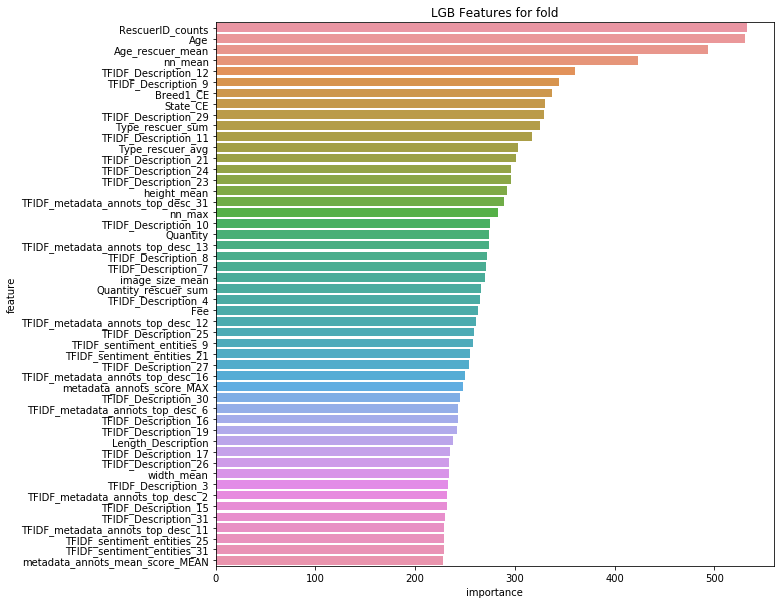

Fold 10

Beginning training...
Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.11616	valid_1's l2: 1.21271
[200]	training's l2: 1.00845	valid_1's l2: 1.16506
[300]	training's l2: 0.935953	valid_1's l2: 1.14349
[400]	training's l2: 0.880823	valid_1's l2: 1.12968
[500]	training's l2: 0.834967	valid_1's l2: 1.12517
[600]	training's l2: 0.794134	valid_1's l2: 1.12411
[700]	training's l2: 0.756365	valid_1's l2: 1.12259
Early stopping, best iteration is:
[663]	training's l2: 0.770008	valid_1's l2: 1.12166
Training took 0.04 minutes.
Prediction took 0.00 minutes.


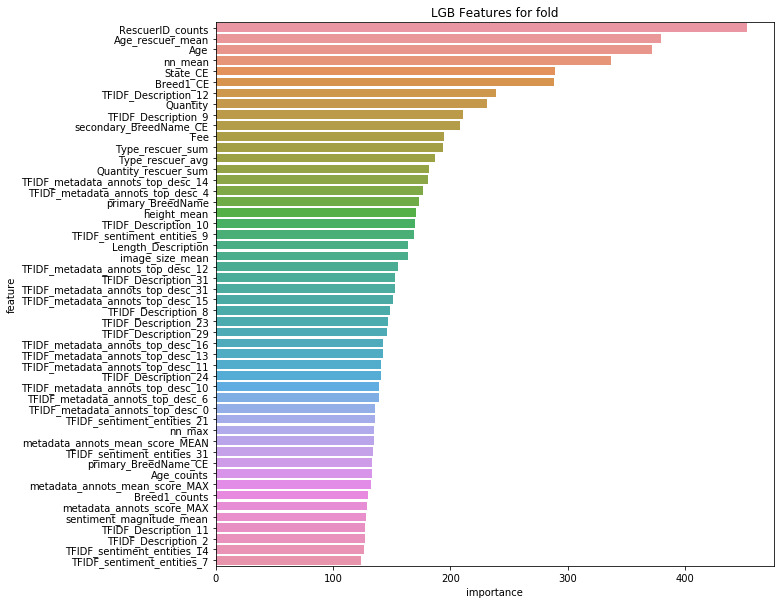

In [381]:
res = train_and_test_model(X_trn, y_trn, X_test, lgb_params, num_folds=10, use_group_kfold=True)
# res = train_and_test_model(X_trn, y_trn, X_test, xgb_params, model_type='xgb', num_folds=10, use_group_kfold=True)

In [63]:
y_bin = np.zeros(y_trn.shape)
y_bin[y_trn == 4] = 1

In [365]:
# bin_res = train_and_test_model(X_trn, y_bin, X_test, bin_params, num_folds=10, use_group_kfold=True)

In [382]:
optR = OptimizedRounder()
optR.fit(res['val_preds'], y_trn.values)
coefficients = optR.coefficients()

valid_pred = optR.predict(res['val_preds'], coefficients)
qwk = quadratic_weighted_kappa(y_trn.values, valid_pred)
print("QWK = ", qwk)
print(coefficients)
coefficients_2 = (np.array(coefficients) + np.array([0.5, 1.5, 2.5, 3.5]))/2
valid_pred = optR.predict(res['val_preds'], coefficients_2)
qwk = quadratic_weighted_kappa(y_trn.values, valid_pred)
print("QWK = ", qwk)

QWK =  0.4456379264207737
[ 0.53115772  2.12042786  2.56276306  2.94578486]
QWK =  0.40630387569021653


In [66]:
print(coefficients)

[ 0.56082361  2.15388664  2.51071345  2.89188768]


In [67]:
def plot_pred(pred):
    sns.distplot(pred, kde=True, hist_kws={'range': [0, 5]})

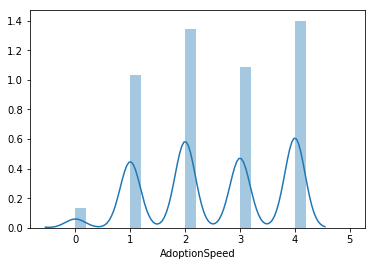

In [68]:
plot_pred(y_trn)

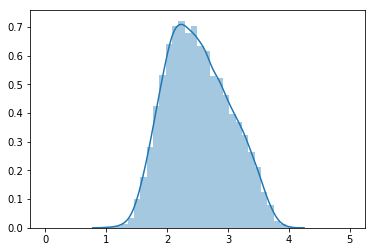

In [383]:
plot_pred(res['val_preds'])

In [71]:
coefficients

array([ 0.56082361,  2.15388664,  2.51071345,  2.89188768])

In [72]:
coefficients_ = coefficients.copy()

train_predictions = optR.predict(res['val_preds'], coefficients_).astype(np.int8)
print('train pred distribution: {}'.format(Counter(train_predictions)))
test_predictions = optR.predict(res['averaged_prediction'], coefficients_).astype(np.int8)
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({1: 4185, 2: 3748, 4: 3720, 3: 3340})
test pred distribution: Counter({1: 1200, 2: 965, 4: 960, 3: 823})


In [73]:
Counter(train_predictions)

Counter({1: 4185, 2: 3748, 3: 3340, 4: 3720})

In [74]:
Counter(test_predictions)

Counter({1: 1200, 2: 965, 3: 823, 4: 960})

In [75]:
submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions})
submission.to_csv('submission.csv', index=False)
submission.head()

,AdoptionSpeed,PetID
0,2,378fcc4fc
1,4,73c10e136
2,4,72000c4c5
3,4,e147a4b9f
4,4,43fbba852
